# 3rd practice: Neural Networks
* **Course**: Artificial Intelligence
* **University**: Universitat Rovira i Virgili

In this practice students will explore the following fundamentals of machine learning:
* Data analysis
* Preprocessing
* Basic design of Multi-Layer Perceptrons (MLP)
* Training of neural networks
* Results analysis
* Decision making / Critical thinking

While reading this notebook, please note the following information:
* Each section (and subsection) has a title and a brief description of its contents.
* If a section (or subsection) title starts with `Student`, the student has work to do inside it, adding code and/or text.
* If the title of a section begins with `Teacher`, all its content (including subsections) is part of the work statement. Subsequently, it **MUST NOT** be modified.
* Sections must be executed in order.
* **<font color='lightgreen'>Please enter your full name in the next cell in this section and run it BEFORE going any further.</font>**

## External resources
Please, read the following tutorials to get an introduction to Google Colab and the Pandas library:
* https://colab.research.google.com/notebooks/basic_features_overview.ipynb
* https://colab.research.google.com/notebooks/mlcc/intro_to_pandas.ipynb

## Deliverable
It is an **individual** practice. The student only needs to deliver **this notebook** including the answers. The file must have as name `P3_[Name]_[Surname/s].ipynb`, replacing `[Name]` and `[Surname/s]` with those from the student.

## Evaluation
To be accepted, all practices delivered must contain at least **one solution with a preprocessing step** and **one solution with a modified neural network**.
A third solution with a second preprocessing step will be valued.

<font color='orange'>**Similar or identical practices will get a grade of 0.**</font>

In [1]:
STUDENT_NAME = "GERARD PASCUAL FONTANILLES" # @param {type:"string"}

# Teacher: Initialization
Defines the **Imports** and **Device** for the practice. More details in each subsection.

## Imports
The following code cell determines the available packages/libraries.

**You CANNOT add any other import, neither here nor anywhere else in the code.**

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Device
Checks if there is a GPU for training the neural networks. If not, the CPU will be used. It is recommended to first test if the preprocessing and model definition are correct in a CPU-based environment and then switch to the GPU-based environment for training.

In [3]:
if torch.cuda.is_available():
  DEVICE = "cuda"
  print("There is GPU available. Printing GPU information:")
  !nvidia-smi
else:
  DEVICE = "cpu"
  print("There is no GPU available, using CPU.")

There is GPU available. Printing GPU information:
Tue May 21 23:17:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 970         Off | 00000000:29:00.0  On |                  N/A |
|  0%   55C    P5              25W / 200W |    455MiB /  4096MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------

# Teacher: Base code
<a name="base_code"></a>

Code available for use in the `Student` sections.

## Data loading
This loads the `CarsData.csv` file (available in Moodle) as a Pandas dataframe. **The file must first be loaded into the environment folder** 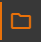. If you use a web browser *other* than Google Chrome, the loading may fail (e.g., the loading circle is red and never ends).

This dataset will be used for the **Manufacturer classification task**, where the machine learning model aims to predict/output the Manufacturer of a car using the rest of features as inputs.

The dataset was extracted from [this website](https://www.kaggle.com/datasets/meruvulikith/90000-cars-data-from-1970-to-2024/data). The dataframe to be used in practice is a 25% subsample of the full dataset, different from that of other students.

In [4]:
LABEL_COL_NAME = "Manufacturer" # Global constant

def data_loading(file_name):
  original_df = pd.read_csv(file_name)
  original_df = original_df.drop(columns=["model"]) # Model column is not available
  original_df

  # Infer column types
  infer_type = lambda x: x if pd.api.types.is_numeric_dtype(x) else pd.Categorical(x)
  original_df = original_df.apply(infer_type, axis=0)

  # Select subset
  frac=0.25
  random_seed = hash(STUDENT_NAME) % (2**32-1) # Seed must be between 0 and 2**32 - 1
  student_df = original_df.sample(frac=frac, random_state=random_seed).reset_index()
  student_df = student_df.drop(columns=["index"])

  return student_df

## Analysis
Functions that facilitate the data distribution analysis for the [Student: Exploratory data analysis](#data_analysis) section.

In [5]:
def feature_histogram(df, column_name):
    column_data = df[column_name]

    if pd.api.types.is_numeric_dtype(column_data):
        plt.hist(column_data, bins=10)
    else:
        value_counts = column_data.value_counts()
        value_counts.plot(kind='bar')

    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(column_name))
    plt.show()
    
def feature_stats(df, column_name, verbose=True):
  stats = {}
  column_data = df[column_name]

  # Numerical
  if pd.api.types.is_numeric_dtype(column_data):
    stats["Min"] = column_data.min()
    stats["Max"] = column_data.max()
    stats["Mean"] = column_data.mean()
    stats["Std"] = column_data.std()

  # Categorical
  elif pd.api.types.is_categorical_dtype(column_data):
    stats["Unique"] = column_data.value_counts()

  if verbose and len(stats) > 0:
    stats_str = ""
    for name, value in stats.items():
      stats_str += f" {name}={value} |"
    print(f"Stats of {column_name}:{stats_str}")

  return stats

def features_relationship(df, column_name_1, column_name_2):
    data1 = df[column_name_1]
    data2 = df[column_name_2]

    # Both columns are numerical
    if pd.api.types.is_numeric_dtype(data1) and pd.api.types.is_numeric_dtype(data2):
        plt.scatter(data1, data2)
        plt.xlabel(column_name_1)
        plt.ylabel(column_name_2)
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # Both columns are categorical
    elif pd.api.types.is_categorical_dtype(data1) and pd.api.types.is_categorical_dtype(data2):
        cross_table = pd.crosstab(data1, data2)
        cross_table.plot(kind='bar', stacked=True)
        plt.xlabel(column_name_1)
        plt.ylabel('Frequency')
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # A column is numerical and the other categorical
    else:
        # Check which is which
        if pd.api.types.is_categorical_dtype(data1):
            categorical_column = column_name_1
            numerical_column = column_name_2
        else:
            categorical_column = column_name_2
            numerical_column = column_name_1

        # Get data
        categorical_data = df[categorical_column]
        numerical_data = df[numerical_column]

        # Convert categorical data to numeric representation
        categorical_codes = categorical_data.astype('category').cat.codes

        # Plot
        plt.scatter(numerical_data, categorical_codes)
        plt.xlabel(numerical_column)
        plt.ylabel(categorical_column)
        plt.title('Relationship between {} and {}'.format(numerical_column, categorical_column))
        plt.yticks(ticks=categorical_codes.unique(), labels=categorical_data.unique()) # Set sticks labels as category names
        plt.show()

## PyTorch dataset
Function that transforms the preprocessed dataframe into the training and test datasets using the PyTorch TensorDataset class. To be used in the [Experiments](#experiments) section.

In [6]:
def df_to_dataset(preprocessed_df, label_col_name=LABEL_COL_NAME):
  if not label_col_name in preprocessed_df.columns:
    raise Exception(f"Dataframe MUST contain the label column [{label_col_name}], preferably in the last column.")

  # Obtain inputs and labels
  columns_to_discard = [col_name for col_name in preprocessed_df.columns if col_name == label_col_name]
  x = preprocessed_df.drop(columns=columns_to_discard)
  y = preprocessed_df[label_col_name]

  # Encode labels (string to identifier integer)
  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(y)

  # Convert data to PyTorch tensors
  x_tensor = torch.tensor(x.values, dtype=torch.float)
  y_tensor = torch.tensor(y, dtype=torch.long)

  # Train-test split: 80% train, 20% test
  x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42, shuffle=True)

  # Create PyTorch datasets
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  # Get additional information for the model
  input_size = x_train_tensor.shape[1]
  num_classes = len(label_encoder.classes_)

  return train_dataset, test_dataset, input_size, num_classes, label_encoder

## Model
Basic function for the model creation and its movement to the corresponding DEVICE (GPU or CPU). To be used in the [Experiments](#experiments) section.

In [7]:
def create_model(model_class, input_size, num_classes, verbose=True):
  model = model_class(input_size, num_classes)
  model.to(DEVICE)

  if verbose:
    num_parameters = 0
    for layer in model.parameters():
      num_parameters += layer.nelement() * layer.element_size()
    print(f"The model has {num_parameters} parameters")

  return model

## Training
Function that trains a **model** with a **dataset**, for a **number of epochs** and using a specific **learning rate (lr)**. To be used in the [Experiments](#experiments) section.

In [8]:
def train(model, dataset, num_epochs, lr):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create PyTorch dataloader
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Set up loss evolution plot
    losses = []
    plt.ion()
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Evolution')
    line, = ax.plot([], [])

    # Training loop
    for epoch in range(num_epochs):
        # Set model to train mode
        model.train()

        epoch_loss = 0.0
        num_batches = 0

        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update epoch loss
            epoch_loss += loss.item()
            num_batches += 1

        # Update lists for loss plotting
        mean_epoch_loss = epoch_loss / num_batches
        losses.append(mean_epoch_loss)

        # Update plot
        line.set_ydata(losses)
        line.set_xdata(range(1, len(losses)+1))
        ax.relim()
        ax.autoscale_view()
        display.clear_output(wait=True)
        display.display(plt.gcf())

        # Print specific epoch info
        print(f'Epoch [{epoch+1}/{num_epochs}] | Mean epoch loss: {mean_epoch_loss:.4f}')

    # Turn off interactive mode and show plot
    plt.ioff()
    plt.close()

    return losses

## Evaluation
Functions for the result analysis of the [Experiments](#experiments) section. In particular, for the analysis of [classification accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy?hl=es-419) and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).


In [9]:
def evaluate(model, dataset):
  # Create dataloader
  eval_loader = DataLoader(dataset, batch_size=256, shuffle=False)

  model.eval()  # Set model to evaluation mode
  with torch.no_grad():
      correct = 0
      total = 0
      all_targets = np.empty(len(dataset), dtype=int)
      all_predicted = np.empty_like(all_targets)
      for inputs, targets in eval_loader:
          # Move data to GPU
          inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

          # Forward pass
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)

          # Store targets and predicted labels
          all_targets[total:total+targets.size(0)] = targets.cpu().numpy()
          all_predicted[total:total+targets.size(0)] = predicted.cpu().numpy()

          # Update total and correct predictions
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

      accuracy = correct / total

  return accuracy, all_targets, all_predicted


def plot_confusion_matrix(all_targets, all_predicted, label_encoder):
  # Calculate confusion matrix
  cm = confusion_matrix(all_targets, all_predicted)

  # Plot confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

# Student: Exploratory data analysis
<a name="data_analysis"></a>

In this section, the student will have to perform the following tasks:
* Load the dataset.
* Analyze each feature's data distribution using plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per feature) about them.
* Analyze relevant relationships between pairs of features' data distributions with plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per relationship) about them. Focus only on the important pairs to avoid overwhelming combinations.

In [10]:
df = data_loading("CarsData.csv") # load the dataset

In [11]:
df.head() # Show the first rows of the dataframe to check the data

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,2019,15989,Automatic,12192,Petrol,145,55.5,1.5,BMW
1,2014,14000,Manual,53460,Diesel,30,60.1,2.0,Audi
2,2019,24950,Automatic,9469,Diesel,145,60.1,2.0,BMW
3,2019,20890,Semi-Auto,6588,Diesel,145,65.7,1.5,merc
4,2016,11000,Automatic,100170,Diesel,20,68.9,2.0,BMW


In [12]:
df.info() # Check the data types of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24428 entries, 0 to 24427
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          24428 non-null  int64   
 1   price         24428 non-null  int64   
 2   transmission  24428 non-null  category
 3   mileage       24428 non-null  int64   
 4   fuelType      24428 non-null  category
 5   tax           24428 non-null  int64   
 6   mpg           24428 non-null  float64 
 7   engineSize    24428 non-null  float64 
 8   Manufacturer  24428 non-null  category
dtypes: category(3), float64(2), int64(4)
memory usage: 1.2 MB


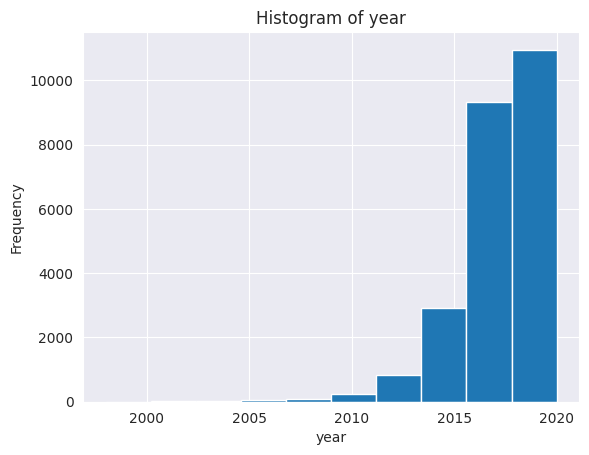

Stats of year: Min=1998 | Max=2020 | Mean=2017.0626739806778 | Std=2.11598286256353 |


{'Min': 1998, 'Max': 2020, 'Mean': 2017.0626739806778, 'Std': 2.11598286256353}

In [13]:
feature_histogram(df, "year")
feature_stats(df, "year")

# La variable **Year** 
Representa l'any de fabricació del vehicle en la nostra mostra de dades. Aquesta és una variable numèrica amb una distribució lleugerament uniforme, mostrant una tendència cap a un increment en els vehicles més nous. Aquest increment es pot atribuir al fet que la mostra de vehicles és més gran en els anys més recents.

**Estadístiques Descriptives**
* Mínim: 1998
* Màxim: 2020
* Mitjana: 2017.07
* Desviació Estàndard: 2.11

Aquestes estadístiques ens indiquen que la major part dels vehicles de la nostra mostra són relativament nous, amb la mitjana situada en l'any 2017. A més, la desviació estàndard baixa suggereix que la majoria dels vehicles no s'allunyen gaire d'aquesta mitjana.

**Distribució per Any**

La distribució de la variable **Year** pot ser millor visualitzada a través de la següent taula que mostra la quantitat de vehicles fabricats cada any:

In [14]:
df["year"].value_counts() # total de vehicles per any

year
2019    6512
2017    5345
2016    3972
2018    3406
2015    1896
2020    1031
2014    1007
2013     668
2012     166
2011      98
2010      79
2009      62
2008      53
2007      44
2006      26
2005      23
2004      10
2003       9
2001       9
2002       9
1999       1
1998       1
2000       1
Name: count, dtype: int64

**Anàlisi de la Distribució**
* **Increment Recents**: La quantitat de vehicles fabricats augmenta significativament en els anys més recents, especialment a partir de l'any 2015. El pic més alt es troba l'any 2019 amb 6598 vehicles.
* **Reducció de Mostra en Anys Anteriors**: La quantitat de vehicles fabricats disminueix considerablement amb només 1261 vehicles registrats anteriors al 2014.
* **Distribució Uniforme amb Tendència a l'Increment**: Tot i que la distribució és bastant uniforme, hi ha una clara tendència cap a l'increment en els vehicles més nous, com es pot veure amb l'augment de la quantitat de vehicles a partir de 2015.

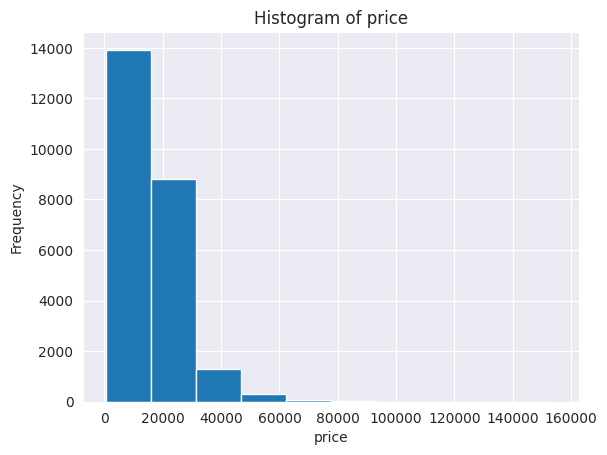

Stats of price: Min=450 | Max=154998 | Mean=16697.07118879974 | Std=9771.396575483926 |


{'Min': 450,
 'Max': 154998,
 'Mean': 16697.07118879974,
 'Std': 9771.396575483926}

In [15]:
feature_histogram(df, "price")
feature_stats(df, "price")

# **Anàlisi de la variable Price**
**Descripció General**
La variable Price representa el preu dels vehicles en la nostra mostra de dades. Aquesta és una variable numèrica amb una distribució que mostra una àmplia variabilitat, reflectint la diversitat de preus en funció de factors com l'any de fabricació, el model, la marca, l'estat del vehicle, entre d'altres.

**Estadístiques Descriptives**
* Mínim: 450
* Màxim: 154998
* Mitjana: 16697.07
* Desviació Estàndard: 9771.39

Aquestes estadístiques ens indiquen que els preus dels vehicles varien significativament dins de la nostra mostra. La mitjana de preu és de 16697.07, la qual cosa suggereix que la major part dels vehicles es situen en una gamma de preus moderada. Tanmateix, la desviació estàndard elevada de 9771.39 indica que hi ha una considerable dispersió dels preus al voltant de la mitjana.

**Anàlisi de la Distribució**
* **Àmplia Variabilitat**: La gran diferència entre el preu mínim (450) i el màxim (154998) demostra una àmplia variabilitat en els preus dels vehicles, incloent-hi vehicles de gamma baixa i gamma alta.
* **Concentració al Voltant de la Mitjana**: Tot i l'àmplia variabilitat, la concentració de la majoria dels preus sembla estar al voltant de la mitjana de 16697.07, amb molts preus dins d'un rang moderat.
* **Possibles Extrems**: La presència de preus molt baixos (450) i molt alts (139559) pot indicar la presència d'extrems o valors atípics que podrien influir en l'anàlisi global dels preus.

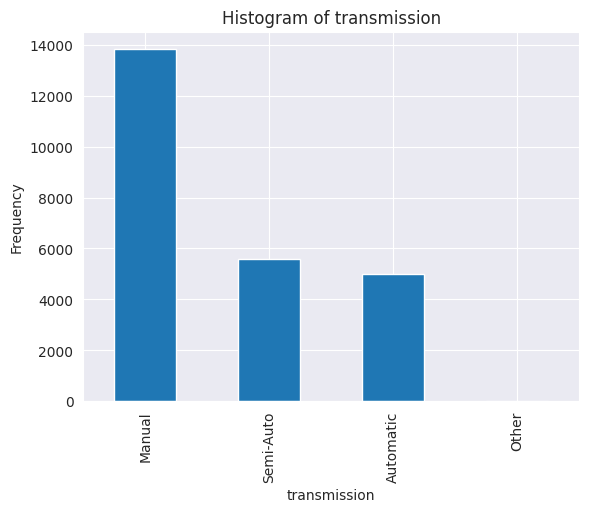

Stats of transmission: Unique=transmission
Manual       13828
Semi-Auto     5605
Automatic     4992
Other            3
Name: count, dtype: int64 |


/tmp/ipykernel_12143/605473294.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(column_data):


{'Unique': transmission
 Manual       13828
 Semi-Auto     5605
 Automatic     4992
 Other            3
 Name: count, dtype: int64}

In [16]:
feature_histogram(df, "transmission")
feature_stats(df, "transmission")

# Variable **Transmission**
La variable **Transmission** representa el tipus de transmissió dels vehicles en la nostra mostra de dades. Aquesta és una variable categòrica amb diverses categories de transmissió.

**Distribució de la Transmissió:**

* **Manual**: 13828
* **Semi-Auto**: 5605
* **Automatic**: 4992
* **Other**: 3

La major part dels vehicles en la mostra tenen una transmissió manual, seguit per Semi-Automàtica i Automàtica. La categoria "Other" és pràcticament negligible amb només 3 vehicles.

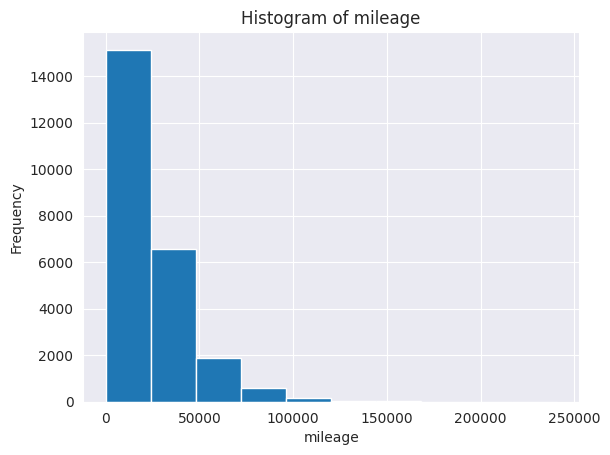

Stats of mileage: Min=1 | Max=240494 | Mean=23205.45775339774 | Std=20970.463598854512 |


{'Min': 1, 'Max': 240494, 'Mean': 23205.45775339774, 'Std': 20970.463598854512}

In [17]:
feature_histogram(df, "mileage")
feature_stats(df, "mileage")

# Variable **Mileage**
La variable **Mileage** representa el quilometratge dels vehicles, és a dir, la distància total recorreguda per cada vehicle.

**Estadístiques Descriptives:**

* **Mínim**: 1
* **Màxim**: 240494
* **Mitjana**: 23205.45
* **Desviació Estàndard**: 20970.46

Aquestes estadístiques indiquen una àmplia variabilitat en el quilometratge dels vehicles. La mitjana de 23205.45 km suggereix que la major part dels vehicles han recorregut una distància moderada. Això no obstant, la desviació estàndard elevada (20970.43) mostra que hi ha una gran dispersió en els valors de quilometratge, amb vehicles que tenen quilometratges molt baixos i altres amb quilometratges molt alts.

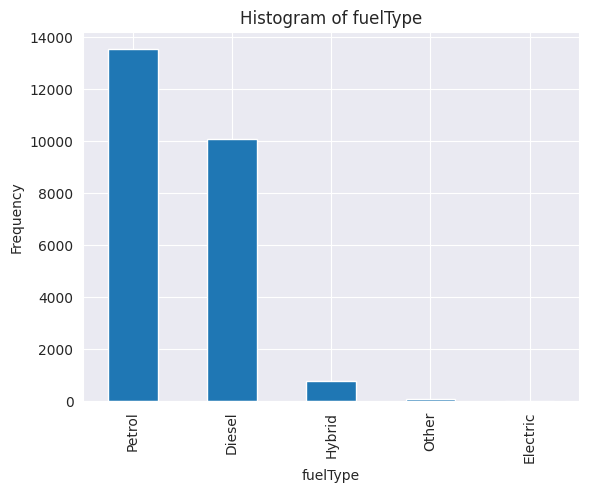

Stats of fuelType: Unique=fuelType
Petrol      13527
Diesel      10062
Hybrid        770
Other          67
Electric        2
Name: count, dtype: int64 |


/tmp/ipykernel_12143/605473294.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(column_data):


{'Unique': fuelType
 Petrol      13527
 Diesel      10062
 Hybrid        770
 Other          67
 Electric        2
 Name: count, dtype: int64}

In [18]:
feature_histogram(df, "fuelType")
feature_stats(df, "fuelType")

# Variable **FuelType**
La variable **FuelType** representa el tipus de combustible que utilitzen els vehicles. Aquesta és una variable categòrica amb diverses categories de tipus de combustible.

Distribució del Tipus de Combustible:

* **Petrol**: 13527
* **Diesel**: 10062
* **Hybrid**: 770
* **Other**: 67
* **Electric**: 2

Els vehicles que utilitzen gasolina són majoritaris, seguits pels que utilitzen dièsel. Els vehicles híbrids representen una petita part de la mostra, mentre que els vehicles elèctrics i altres tipus de combustible són gairebé inexistents.

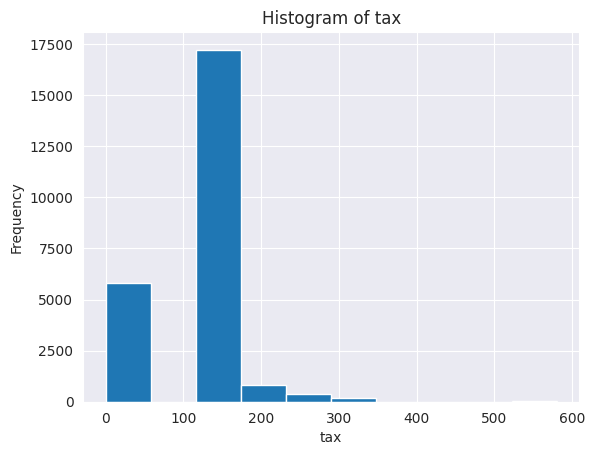

Stats of tax: Min=0 | Max=580 | Mean=120.08105452759129 | Std=63.967832161809014 |


{'Min': 0, 'Max': 580, 'Mean': 120.08105452759129, 'Std': 63.967832161809014}

In [19]:
feature_histogram(df, "tax")
feature_stats(df, "tax")

# Variable **Tax**
La variable **Tax** representa l'impost anual del vehicle.

**Estadístiques Descriptives**:

* **Mínim**: 0
* **Màxim**: 580
* **Mitjana**: 120.08
* **Desviació Estàndard**: 63.96

Aquestes estadístiques mostren una variabilitat considerable en l'import de l'impost anual dels vehicles. La mitjana de 120.08 suggereix que la majoria dels vehicles tenen un impost moderat, mentre que la desviació estàndard de 63.96 indica que hi ha una dispersió significativa al voltant de la mitjana, amb alguns vehicles pagant un impost molt baix o fins i tot nul, i altres pagant impostos molt més elevats.

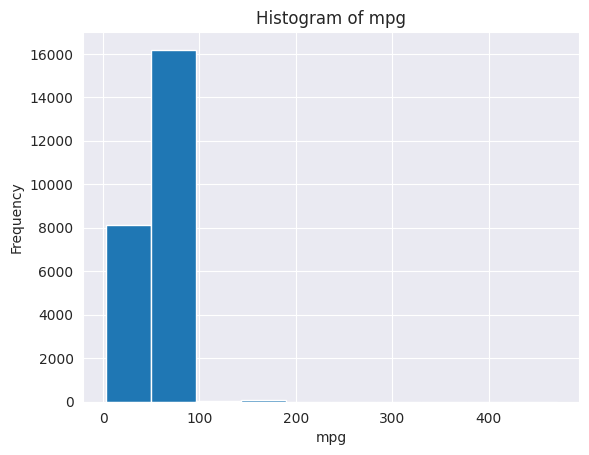

Stats of mpg: Min=2.8 | Max=470.8 | Mean=55.17378254462092 | Std=15.47750204621969 |


{'Min': 2.8, 'Max': 470.8, 'Mean': 55.17378254462092, 'Std': 15.47750204621969}

In [20]:
feature_histogram(df, "mpg")
feature_stats(df, "mpg")

# Variable **MPG**
La variable **MPG (milles per galó)** representa l'eficiència de combustible dels vehicles en la nostra mostra de dades. Aquesta és una variable numèrica que indica quantes milles pot recórrer un vehicle amb un galó de combustible.

**Estadístiques Descriptives**:

* **Mínim**: 2.8
* **Màxim**: 470.8
* **Mitjana**: 55.17
* **Desviació Estàndard**: 15.47

Aquestes estadístiques mostren que l'eficiència de combustible dels vehicles varia considerablement. La mitjana de 55.17 MPG indica una eficiència de combustible moderada, mentre que la desviació estàndard de 15.47 suggereix una certa dispersió al voltant de la mitjana. Els valors extrems (molt baixos i molt alts) poden indicar errors de dades o vehicles molt especials.

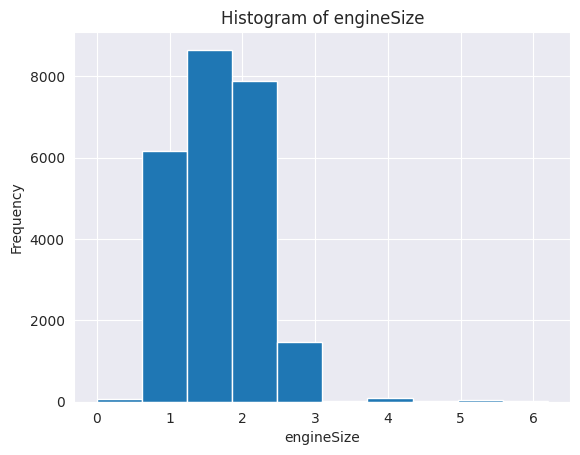

Stats of engineSize: Min=0.0 | Max=6.2 | Mean=1.6609505485508431 | Std=0.5592836159115399 |


{'Min': 0.0, 'Max': 6.2, 'Mean': 1.6609505485508431, 'Std': 0.5592836159115399}

In [21]:
feature_histogram(df, "engineSize")
feature_stats(df, "engineSize")

# Variable **EngineSize**
La variable **EngineSize** representa la mida del motor dels vehicles, mesurada en litres. Aquesta és una variable numèrica que reflecteix la capacitat del motor.

**Estadístiques Descriptives**:

* **Mínim**: 0.0
* **Màxim**: 6.2
* **Mitjana**: 1.66
* **Desviació Estàndard**: 0.56

Aquestes estadístiques indiquen que la mida dels motors dels vehicles varia, amb una mitjana de 1.66 litres i una desviació estàndard de 0.56 litres. La presència d'un mínim de 0.0 litres podria indicar errors en la recollida de dades o vehicles elèctrics que no tenen un motor tradicional de combustió.

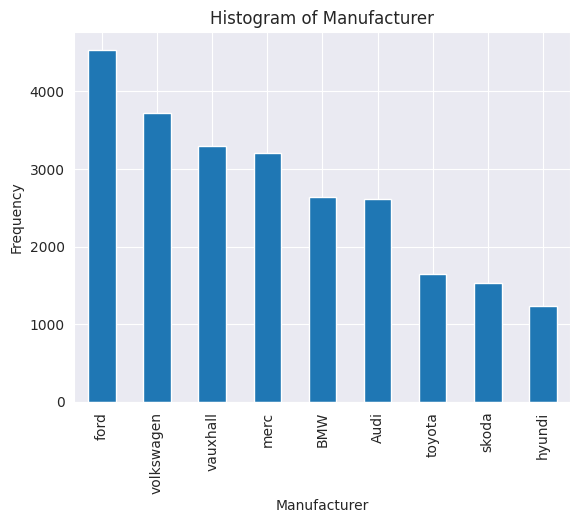

Stats of Manufacturer: Unique=Manufacturer
ford          4537
volkswagen    3725
vauxhall      3301
merc          3210
BMW           2637
Audi          2610
toyota        1652
skoda         1524
hyundi        1232
Name: count, dtype: int64 |


/tmp/ipykernel_12143/605473294.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(column_data):


{'Unique': Manufacturer
 ford          4537
 volkswagen    3725
 vauxhall      3301
 merc          3210
 BMW           2637
 Audi          2610
 toyota        1652
 skoda         1524
 hyundi        1232
 Name: count, dtype: int64}

In [22]:
feature_histogram(df, "Manufacturer")
feature_stats(df, "Manufacturer")

# Variable **Manufacturer**
La variable **Manufacturer** representa el fabricant dels vehicles en la nostra mostra de dades. Aquesta és una variable categòrica amb diverses categories que representen diferents marques de vehicles.

**Distribució dels Fabricants**:

* **Ford**: 4537
* **Volkswagen**: 3725
* **Vauxhall**: 3301
* **Mercedes**: 3210
* **Audi**: 2610
* **BMW**: 2637
* **Toyota**: 1652
* **Skoda**: 1524
* **Hyundai**: 1232

La distribució mostra que Ford és el fabricant més comú en la mostra, seguit per Volkswagen i Vauxhall. Altres fabricants com Mercedes, Audi i BMW també tenen una presència significativa, mentre que marques com Toyota, Skoda i Hyundai tenen una representació menor.

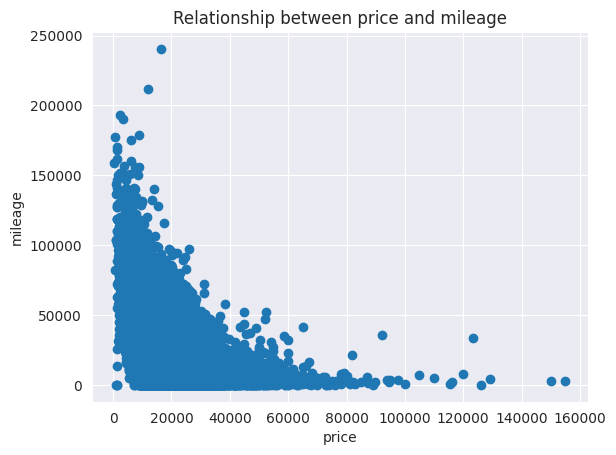

In [23]:
features_relationship(df, "price", "mileage")

# Relació entre Price i Mileage

Aquest gràfic de dispersió mostra la relació entre el preu (Price) i el quilometratge (Mileage) dels vehicles.

**Observacions**:

* **Tendència General**: Hi ha una clara tendència decreixent, on vehicles amb un quilometratge més alt tendeixen a tenir preus més baixos.
* **Concentració**: La majoria dels vehicles es concentren en la franja de preu fins als 40,000 i en la franja de quilometratge fins als 100,000 km.
* **Vehicles Cars**: Vehicles amb preus més alts (superiors a 60,000) tendeixen a tenir un quilometratge relativament baix.
* **Vehicles Amb Alt Quilometratge**: Vehicles amb un quilometratge molt alt (superior a 150,000 km) tenen preus molt baixos, sovint per sota dels 10,000.

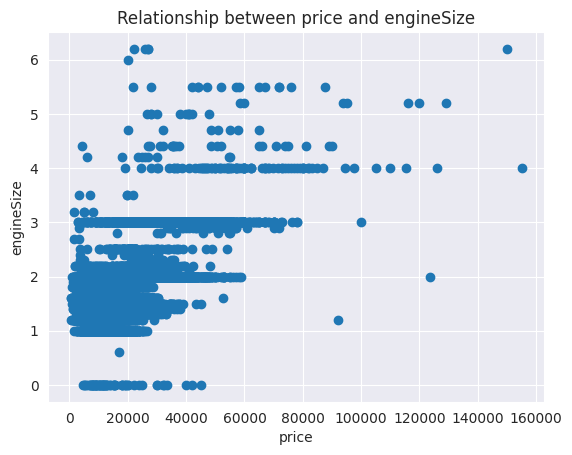

In [24]:
features_relationship(df, "price", "engineSize")

# Relació entre **Price** i **EngineSize**

Aquest gràfic de dispersió mostra la relació entre el preu (Price) i la mida del motor (EngineSize) dels vehicles.

**Observacions**:

* **Dispersió de Preus**: La majoria dels vehicles es troben en una franja de preu fins als 40,000, amb alguns vehicles que arriben fins als 140,000.
* **Mida del Motor**: La mida del motor majoritàriament està concentrada entre 1 i 2 litres, però hi ha variabilitat fins als 6.6 litres.
* **Tendència**: No hi ha una correlació clara i directa entre el preu i la mida del motor en aquest gràfic. Tot i així, els vehicles amb motors més grans tendeixen a estar en els rangs de preu més alts, especialment aquells amb motors per sobre dels 4 litres.
* **Anomalies**: Hi ha alguns punts dispersos que indiquen vehicles amb motors molt grans però preus relativament baixos, i viceversa.

Aquest gràfic suggereix que, si bé hi ha una certa tendència que els vehicles amb motors més grans poden tenir preus més alts, aquesta relació no és estrictament lineal. La variabilitat en el preu per a una determinada mida de motor pot ser influenciada per altres factors com la marca, el model, les característiques addicionals, i l'estat del vehicle.

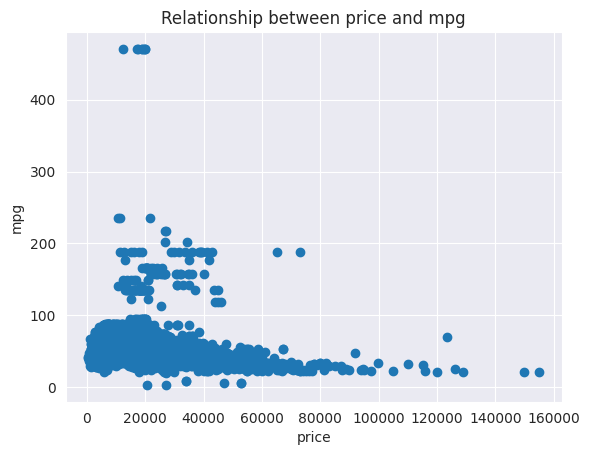

In [25]:
features_relationship(df, "price", "mpg")

# Relació entre **preu i MPG**
**Observació de tendències**:

No hi ha una relació lineal clara entre el preu i el mpg.
La majoria dels cotxes s'agrupen al voltant de preus més baixos (0-20.000) i mpg més baixos (0-100).
Hi ha valors atípics amb valors de mpg molt elevats (per sobre de 200), que poden indicar anomalies en les dades o tipus de vehicles molt específics (possiblement vehicles elèctrics o híbrids).

**Estadístiques**:
* Els cotxes més barats solen tenir una àmplia gamma de valors de mpg.
* Els cotxes de preu elevat generalment no mostren valors de mpg excepcionalment elevats, cosa que podria indicar vehicles de luxe o d'alt rendiment amb una eficiència de combustible més baixa.

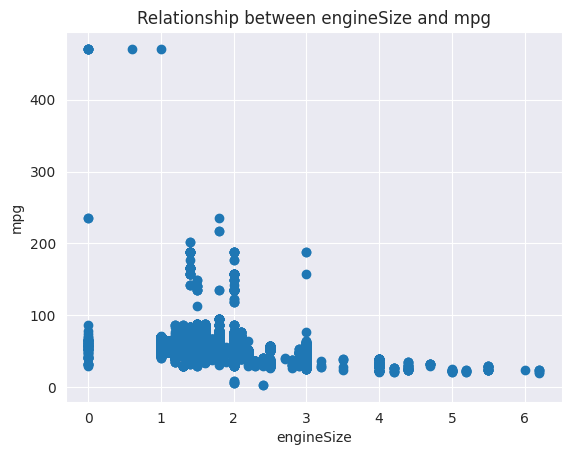

In [26]:
features_relationship(df, "engineSize", "mpg")

# Relació entre EngineSize i MPG

Aquest gràfic de dispersió mostra la relació entre la mida del motor (EngineSize) i l'eficiència de combustible (MPG) dels vehicles.

**Observacions**:

* **Tendència General**: Hi ha una tendència inversa clara entre la mida del motor i l'eficiència de combustible. A mesura que augmenta la mida del motor, la MPG tendeix a disminuir.
* **Mida del Motor Petita**: Vehicles amb motors petits (menys d'1 litre) mostren una gran variabilitat en l'eficiència de combustible, incloent alguns amb valors molt alts de MPG.
* **Mida del Motor Gran**: Vehicles amb motors grans (superiors a 3 litres) tenen una eficiència de combustible relativament baixa, situant-se principalment per sota dels 50 MPG.
* **Anomalies**: Alguns punts dispersos mostren vehicles amb motors molt grans o molt petits amb una MPG inesperadament alta o baixa, el que pot indicar vehicles especials o errors de dades.

/tmp/ipykernel_12143/605473294.py:50: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(data1) and pd.api.types.is_categorical_dtype(data2):
/tmp/ipykernel_12143/605473294.py:60: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(data1):


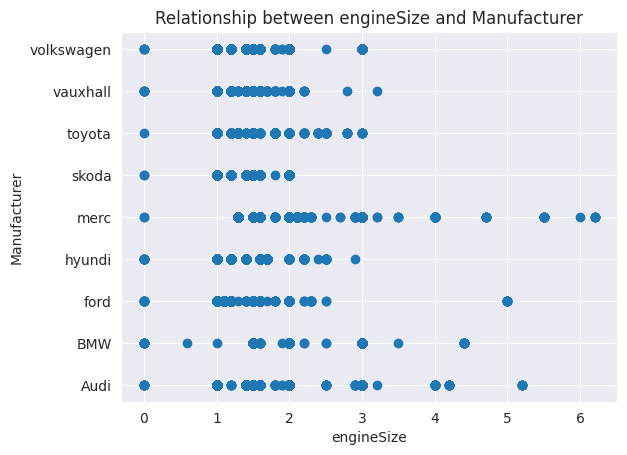

In [27]:
features_relationship(df, "Manufacturer", "engineSize")

# Relació entre **EngineSize i Manufacturer**

Aquest gràfic de dispersió mostra la relació entre la mida del motor (EngineSize) i el fabricant del vehicle (Manufacturer).

**Distribució de Mida del Motor per Fabricant**:
* **Volkswagen, Vauxhall, Toyota, Skoda, Hyundai**: Aquests fabricants majoritàriament produeixen vehicles amb motors que varien entre 0 i 3 litres.
* **Mercedes-Benz**: Aquesta marca mostra una major varietat en la mida del motor, incloent motors més grans fins a 6 litres.
* **Ford**: La mida del motor dels vehicles Ford és principalment entre 0 i 3 litres, amb alguns vehicles amb motors més grans.
* **BMW i Audi**: Aquests fabricants tenen vehicles amb una varietat més àmplia en la mida del motor, incloent motors més grans fins a 5 i 6 litres.

Aquest gràfic indica que hi ha una diversitat significativa en les mides dels motors segons el fabricant. Marques com Mercedes-Benz, BMW i Audi tenen tendència a oferir una gamma més àmplia de mides de motor, incloent-hi motors més grans. Altres marques com Volkswagen, Vauxhall, Toyota, Skoda i Hyundai es concentren més en motors de mida petita a mitjana. Tots els fabricants disposen de vehicles amb motors de 0 litres, podria indicar errors en la recollida de dades o vehicles elèctrics que no tenen un motor tradicional de combustió.

/tmp/ipykernel_12143/605473294.py:50: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(data1) and pd.api.types.is_categorical_dtype(data2):


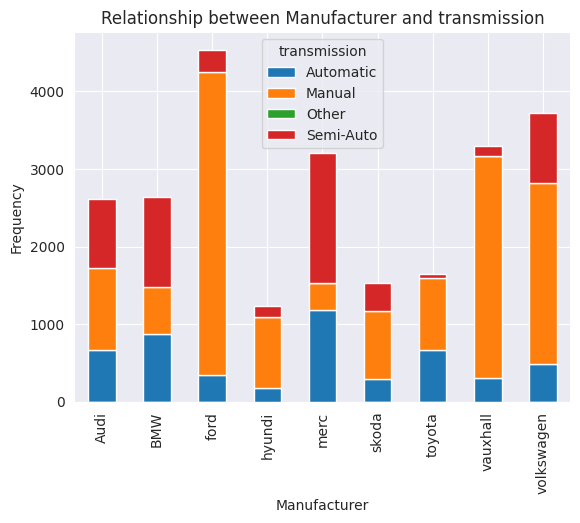

In [28]:
features_relationship(df, "Manufacturer", "transmission")

# Relació entre **fabricant i transmissió**
**Distribució de transmissió**:

* **Audi**: distribució equilibrada d'automàtica, manual i semiautomàtica.
* **BMW**: distribució equilibrada similar amb una mica més d'automàtics.
* **Ford**: Transmissions predominantment manuals.
* **Hyundai**: més manuals que automàtics, amb alguns semiautomàtics.
* **Mercedes**: Major nombre d'automàtiques, Semiautomàtic important.
* **Skoda**: Predominantment manuals.
* **Toyota**: Majoritàriament manuals, menys automàtiques i semiautomàtiques.
* **Vauxhall**: manual dominant, seguit d'automàtics i alguns semi-automàtics.
* **Volkswagen**: equilibrat amb un nombre lleugerament superior de manuals i automàtics en comparació amb els semiautomàtics.

**Estadístiques**:
* Ford i Skoda mostren una forta preferència per les transmissions manuals.
* Marques de luxe com Mercedes i BMW s'inclinen més cap a les transmissions automàtiques.
* Hi ha una variació significativa en la preferència del tipus de transmissió entre els diferents fabricants, reflectint diferents estratègies de mercat i preferències dels consumidors.

# Teacher: Baseline solution
<a name="baseline"></a>
This defines the most basic (and unsuccessful) ready-to-use solution for the **Manufacturer classification task**. It includes the main components:
* Preprocessing
* Model
* Training
* Evaluation

Nonetheless, there are a lot of important things missing, as can be seen from the very poor results. Use this as inspiration for your [Solution 1A](#solution_1a), that **must** be better than this.

## Preprocessing

In [29]:
def preprocessing_0(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  columns_to_use = ["year", "price", "mileage", "tax", "mpg", "engineSize"] + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  column_transformer = ColumnTransformer([('onehot', OneHotEncoder(), categorical_cols)],
                                         remainder='passthrough')
  preprocessed_df = pd.DataFrame(column_transformer.fit_transform(preprocessed_df))
  # IMPORTANT: Student's can't use ColumnTransformer or similars, only Pandas functions

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_0(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

In [30]:
input_size

15

In [31]:
num_classes

9

## Model

In [32]:
class Model_0(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_0, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, num_classes), # Input layer to output layer, tantes neurones com classes
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model = create_model(Model_0, input_size, num_classes)

The model has 576 parameters


## Training

In [33]:
%%time
losses = train(model, train_dataset, num_epochs=5, lr=0.001)

Epoch [5/5] | Mean epoch loss: 2.2196
CPU times: user 5.55 s, sys: 439 ms, total: 5.99 s
Wall time: 5.94 s


## Evaluation

Train accuracy: 15.23%
Test accuracy: 15.25%


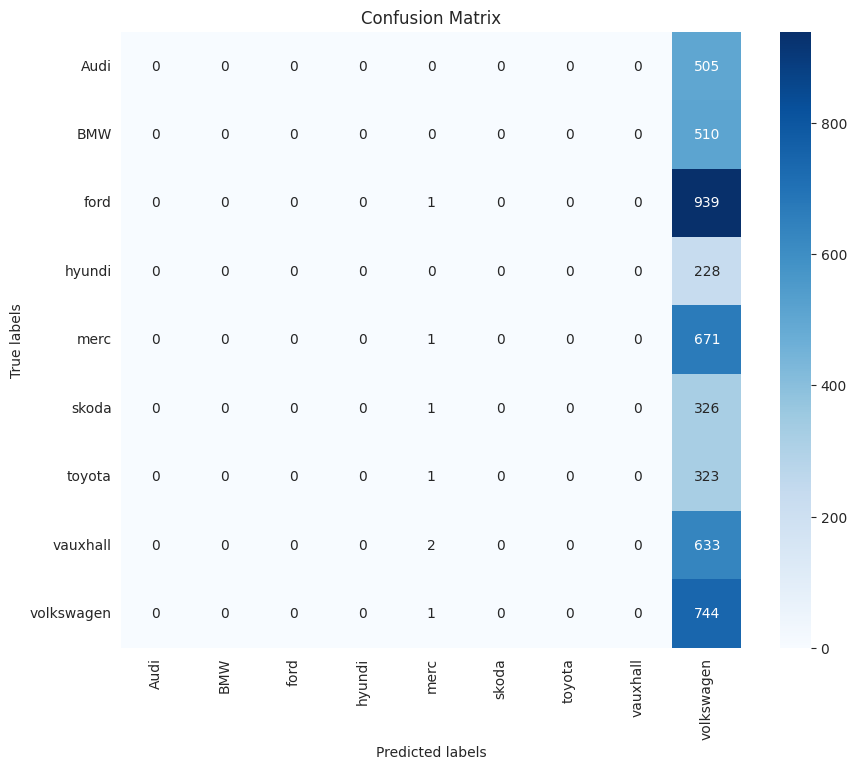

In [34]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

# Student: Experiments
<a name="experiments"></a>

In this section, the student will have to create two or three consequent solutions for the **Manufacturer classification task**. Each solution must contain the following components:
* **Idea**: What is the target/reasoning of the solution (e.g., I observed that the previous model had a very reduced size and I want to explore the effects of using a bigger model).
* **Preprocessing**: Prepare the desired features of your dataframe for the neural network. To this end, students can <font color='orange'>**only use Pandas' functions**</font>.
* **Model**: Definition of the Multi-Layer Perceptron model, **only** using [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers and
 [activations from this list](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).
* **Training**: Perform the learning process trying to maximize the results.
* **Evaluation**: Measuring the performance of the trained model.
* **Results analysis**: Examination of the solution, focusing in:
  * Training
  * Accuracy
  * Confusion matrix
  * Training time

It can be seen that these are the same as for the baseline solution, but adding the **Idea** and **Results analysis** components. An extended analysis of the baseline results will also be requested.

None of the solutions has to be the best/ideal, but all of them must be better than the [baseline](#baseline). The idea is to present consequent solutions, being each one the coherent next step of the previous one (the previous step of [Solution 1A](#solution_1a) is the [baseline](#baseline)). This does not imply that each solution has to improve the results of the previous one, but to modify at least one of the components (i.e., preprocessing or model) in a significant and coherent way.

In particular, we aim for the first two solutions ([Solution 1A](#solution_1a) and [Solution 1B](#solution_1b)) to emphasize preprocessing. Specifically, both will utilize the same basic MLP model (better than that of the [baseline](#baseline)) but experiment with two distinct preprocessing approaches. An explicit comparison of these preprocessing methods and their respective outcomes is necessary. For [Solution 2](#solution_2), the preprocessing method from one of the earlier solutions will be employed. The goal of this final solution is to enhance results by improving/refining the MLP model.

## Analysis of baseline
Provide a comprehensive analysis of the [baseline solution](#baseline). Apart from the results (i.e., **training, accuracy, confusion matrix and runtime**), a review of the solution design (i.e., **preprocessing and model**) is also required. It is not necessary to explain or analysis the code, but the choices. For instance, which features are used and how.

TODO: YOUR ANALYSIS HERE

## Common functions
For avoiding code repetition along all the solutions, you can use this subsection for your common functions and/or classes.

In [35]:
df = data_loading("CarsData.csv")

## Solution 1A: First preprocessing
<a name="solution_1a"></a>

Subsequent of [Baseline](#baseline), it implements a basic MLP (better than the provided at the baseline) and a first option for the preprocessing step.

*Idea**: What is the target/reasoning of the solution (e.g., I observed that the previous model had a very reduced size and I want to explore the effects of using a bigger model).

In [36]:
def preprocessing_1(df):
    preprocessed_df = df.copy()

    # Define columns to use and categorical
    categorical_cols = ["transmission", "fuelType"] 
    numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
    columns_to_use = numerical_cols + categorical_cols

    # Select columns to use
    preprocessed_df = preprocessed_df[columns_to_use]

    # One-hot encoding for categorical columns
    for old_col in categorical_cols:
        # One-hot encoding for that column 
        one_hot_encoding_df = pd.get_dummies(preprocessed_df[old_col])

        # Append the new columns to the preprocessed dataframe
        for new_col in one_hot_encoding_df.columns:
            preprocessed_df[new_col] = one_hot_encoding_df[new_col] * 1  # Convert boolean to int

        # Remove the old categorical column
        del preprocessed_df[old_col]

    
    # Normalize numerical columns
    for col in numerical_cols:
        # Min-max normalization o standard deviation normalization depend de l'anàlisi anterior
        preprocessed_df[col] = ((preprocessed_df[col] - preprocessed_df[col].min()) / (preprocessed_df[col].max() - preprocessed_df[col].min()))
    
    # Label column at the end
    preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

    return preprocessed_df


preprocessed_df1A = preprocessing_1(df)
train_dataset1A, test_dataset1A, input_size1A, num_classes1A, label_encoder1A = df_to_dataset(preprocessed_df1A)

In [37]:
input_size1A

14

In [38]:
num_classes1A

9

In [39]:
train_dataset1A[0]

(tensor([0.7727, 0.0873, 0.0811, 0.0517, 0.1199, 0.2258, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000]),
 tensor(0))

In [40]:
label_encoder1A.classes_

array(['Audi', 'BMW', 'ford', 'hyundi', 'merc', 'skoda', 'toyota',
       'vauxhall', 'volkswagen'], dtype=object)

In [41]:
model1A = create_model(Model_0, input_size1A, num_classes1A)

The model has 540 parameters


In [42]:
import itertools

In [43]:
# Function to initialize the weights of the model
def initialize_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [44]:
# Define the grid of hyperparameters
learning_rates = [0.1, 0.01, 0.001, 0.0001]
num_epochs_list = [5, 10, 20, 50]

# Placeholder for the best hyperparameters
best_lr = None
best_num_epochs = None
best_test_accuracy = 0

# Store results for all combinations
results = []

Epoch [50/50] | Mean epoch loss: 1.9342
Train accuracy: 44.29%
Test accuracy: 44.41%
Best learning rate: 0.001
Best number of epochs: 50
Best test accuracy: 44.47%


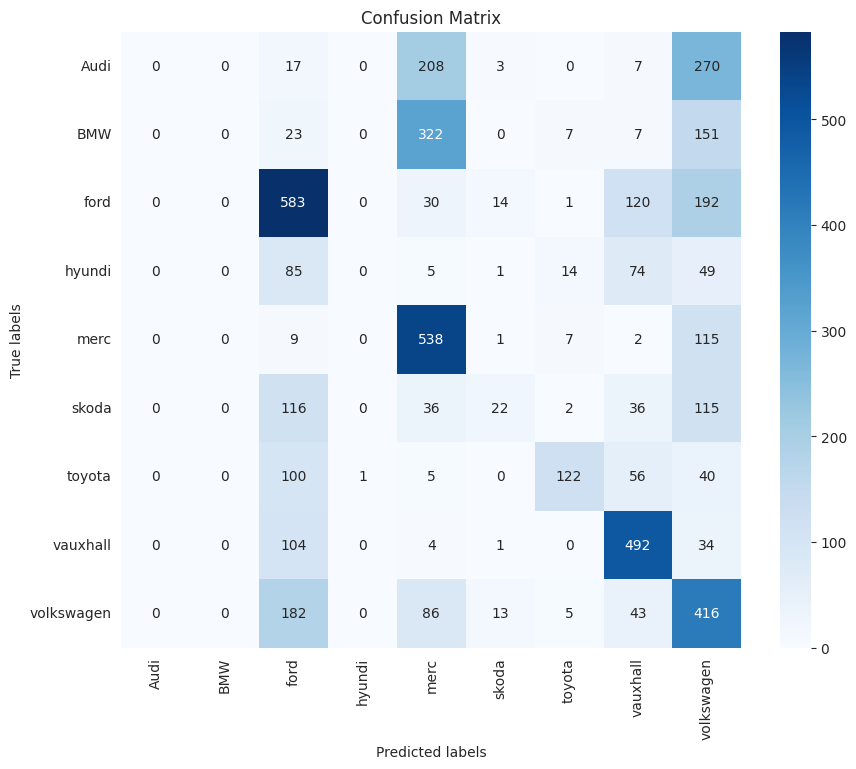


All results:
LR: 0.1, Epochs: 5 => Train Acc: 37.46%, Test Acc: 37.31%
LR: 0.1, Epochs: 10 => Train Acc: 40.43%, Test Acc: 40.50%
LR: 0.1, Epochs: 20 => Train Acc: 41.06%, Test Acc: 41.12%
LR: 0.1, Epochs: 50 => Train Acc: 42.52%, Test Acc: 42.71%
LR: 0.01, Epochs: 5 => Train Acc: 44.14%, Test Acc: 44.25%
LR: 0.01, Epochs: 10 => Train Acc: 44.01%, Test Acc: 44.17%
LR: 0.01, Epochs: 20 => Train Acc: 44.05%, Test Acc: 44.11%
LR: 0.01, Epochs: 50 => Train Acc: 44.27%, Test Acc: 44.39%
LR: 0.001, Epochs: 5 => Train Acc: 44.31%, Test Acc: 44.45%
LR: 0.001, Epochs: 10 => Train Acc: 44.26%, Test Acc: 44.43%
LR: 0.001, Epochs: 20 => Train Acc: 44.27%, Test Acc: 44.37%
LR: 0.001, Epochs: 50 => Train Acc: 44.34%, Test Acc: 44.47%
LR: 0.0001, Epochs: 5 => Train Acc: 44.32%, Test Acc: 44.43%
LR: 0.0001, Epochs: 10 => Train Acc: 44.30%, Test Acc: 44.39%
LR: 0.0001, Epochs: 20 => Train Acc: 44.28%, Test Acc: 44.39%
LR: 0.0001, Epochs: 50 => Train Acc: 44.29%, Test Acc: 44.41%


In [45]:
# Iterate over all combinations of learning rates and number of epochs
for lr, num_epochs in itertools.product(learning_rates, num_epochs_list):
    print(f"Training model with learning rate: {lr} and epochs: {num_epochs}")
    
    # Reinitialize the model's weights
    initialize_weights(model1A)
    
    # Train the model
    losses = train(model1A, train_dataset1A, num_epochs=num_epochs, lr=lr)
    
    # Evaluate the model on the train dataset
    train_accuracy, _, _ = evaluate(model1A, train_dataset1A)
    
    # Evaluate the model on the test dataset
    test_accuracy, test_all_targets, test_all_predicted = evaluate(model1A, test_dataset1A)
    
    # Save the results
    results.append((lr, num_epochs, train_accuracy, test_accuracy))
    
    # Print the accuracies
    print(f'Train accuracy: {train_accuracy*100:.2f}%')
    print(f'Test accuracy: {test_accuracy*100:.2f}%')
    
    # Update the best hyperparameters based on test accuracy
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_lr = lr
        best_num_epochs = num_epochs
        best_test_all_targets = test_all_targets
        best_test_all_predicted = test_all_predicted

# Display the best combination
print(f"Best learning rate: {best_lr}")
print(f"Best number of epochs: {best_num_epochs}")
print(f"Best test accuracy: {best_test_accuracy*100:.2f}%")
    
# Plot confusion matrix for the best model
plot_confusion_matrix(best_test_all_targets, best_test_all_predicted, label_encoder)

print("\nAll results:")
for lr, num_epochs, train_acc, test_acc in results:
    print(f"LR: {lr}, Epochs: {num_epochs} => Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")

## Solution 1B: Second preprocessing solution
<a name="solution_1b"></a>

Subsequent of the [Solution 1A](#solution_1a), uses the same basic MLP but with an alternative preprocessing step.

*Idea**: What is the target/reasoning of the solution (e.g., I observed that the previous model had a very reduced size and I want to explore the effects of using a bigger model).

In [47]:
def preprocessing_2(df, label_col_name):
    preprocessed_df = df.copy()

    categorical_cols = ["transmission", "fuelType"]
    numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
    
    # Handle missing values
    preprocessed_df[categorical_cols] = preprocessed_df[categorical_cols].fillna(preprocessed_df[categorical_cols].mode().iloc[0])
    preprocessed_df[numerical_cols] = preprocessed_df[numerical_cols].fillna(preprocessed_df[numerical_cols].mean())

    # Normalize numerical features manually using min-max scaling
    preprocessed_df[numerical_cols] = (preprocessed_df[numerical_cols] - preprocessed_df[numerical_cols].min()) / (preprocessed_df[numerical_cols].max() - preprocessed_df[numerical_cols].min())

    # Column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), categorical_cols)
        ], remainder='passthrough')  # 'passthrough' leaves numerical columns as they are

    # Apply the transformations
    X = preprocessor.fit_transform(preprocessed_df[categorical_cols + numerical_cols])

    # Extract feature names for the OneHotEncoder
    ohe = preprocessor.transformers_[0][1]
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    feature_names = list(cat_feature_names) + numerical_cols

    # Create a DataFrame with the processed features
    preprocessed_df = pd.DataFrame(X, columns=feature_names)

    # Add the label column back
    preprocessed_df[label_col_name] = df[label_col_name].values

    return preprocessed_df


# Assuming LABEL_COL_NAME is defined and exists in the dataframe
LABEL_COL_NAME = 'Manufacturer'  # Replace 'label' with the actual label column name in your dataframe
preprocessed_df2 = preprocessing_2(df, LABEL_COL_NAME)
train_dataset2, test_dataset2, input_size2, num_classes2, label_encoder2 = df_to_dataset(preprocessed_df2)


In [48]:
input_size2

13

In [49]:
num_classes2

9

In [50]:
train_dataset2[0]

(tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.7727, 0.0873,
         0.0811, 0.0517, 0.1199, 0.2258]),
 tensor(0))

In [51]:
label_encoder2.classes_

array(['Audi', 'BMW', 'ford', 'hyundi', 'merc', 'skoda', 'toyota',
       'vauxhall', 'volkswagen'], dtype=object)

In [70]:
model2 = create_model(Model_0, input_size2, num_classes2)

The model has 504 parameters


In [71]:
# Define the grid of hyperparameters
learning_rates2 = [0.1, 0.01, 0.001, 0.0001]
num_epochs_list2 = [5, 10, 20, 50]

# Placeholder for the best hyperparameters
best_lr2 = None
best_num_epochs2 = None
best_test_accuracy2 = 0

# Store results for all combinations
results2 = []

Epoch [50/50] | Mean epoch loss: 1.9390
Train accuracy: 43.61%
Test accuracy: 43.16%
Best learning rate: 0.01
Best number of epochs: 20
Best test accuracy: 43.16%


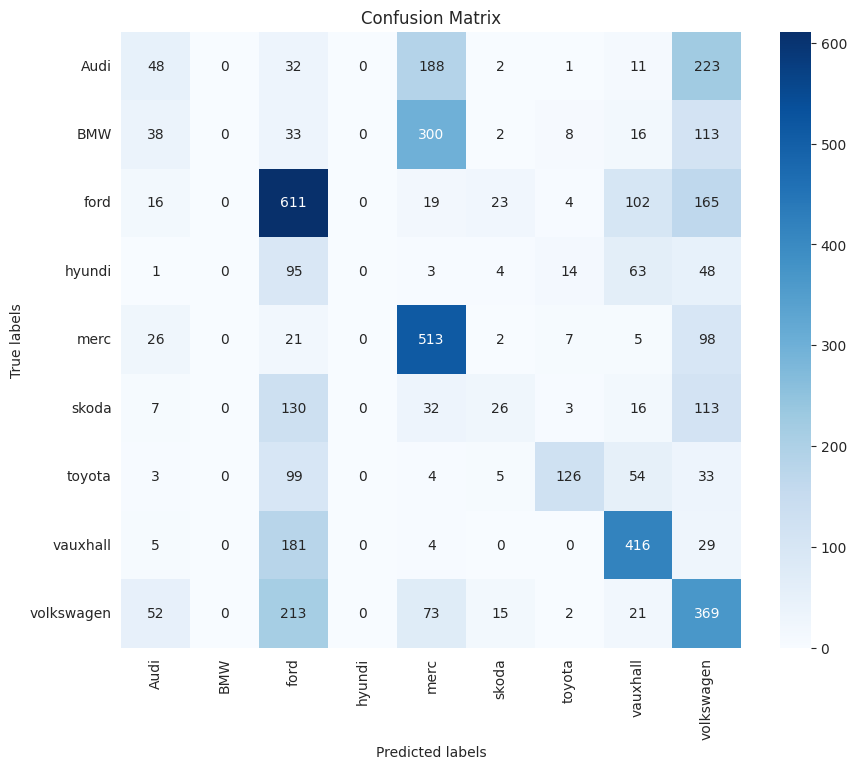


All results:
LR: 0.1, Epochs: 5 => Train Acc: 36.91%, Test Acc: 37.23%
LR: 0.1, Epochs: 10 => Train Acc: 40.97%, Test Acc: 40.87%
LR: 0.1, Epochs: 20 => Train Acc: 41.52%, Test Acc: 41.57%
LR: 0.1, Epochs: 50 => Train Acc: 42.87%, Test Acc: 43.08%
LR: 0.01, Epochs: 5 => Train Acc: 43.31%, Test Acc: 43.12%
LR: 0.01, Epochs: 10 => Train Acc: 43.51%, Test Acc: 43.04%
LR: 0.01, Epochs: 20 => Train Acc: 43.47%, Test Acc: 43.16%
LR: 0.01, Epochs: 50 => Train Acc: 43.42%, Test Acc: 43.08%
LR: 0.001, Epochs: 5 => Train Acc: 43.59%, Test Acc: 43.10%
LR: 0.001, Epochs: 10 => Train Acc: 43.61%, Test Acc: 43.14%
LR: 0.001, Epochs: 20 => Train Acc: 43.61%, Test Acc: 43.12%
LR: 0.001, Epochs: 50 => Train Acc: 43.62%, Test Acc: 43.12%
LR: 0.0001, Epochs: 5 => Train Acc: 43.63%, Test Acc: 43.16%
LR: 0.0001, Epochs: 10 => Train Acc: 43.63%, Test Acc: 43.16%
LR: 0.0001, Epochs: 20 => Train Acc: 43.62%, Test Acc: 43.16%
LR: 0.0001, Epochs: 50 => Train Acc: 43.61%, Test Acc: 43.16%


In [72]:
# Iterate over all combinations of learning rates and number of epochs
for lr, num_epochs in itertools.product(learning_rates2, num_epochs_list2):
    print(f"Training model with learning rate: {lr} and epochs: {num_epochs}")
    
    # Reinitialize the model's weights
    initialize_weights(model2)
    
    # Train the model
    losses = train(model2, train_dataset2, num_epochs=num_epochs, lr=lr)
    
    # Evaluate the model on the train dataset
    train_accuracy, _, _ = evaluate(model2, train_dataset2)
    
    # Evaluate the model on the test dataset
    test_accuracy, test_all_targets, test_all_predicted = evaluate(model2, test_dataset2)
    
    # Save the results
    results2.append((lr, num_epochs, train_accuracy, test_accuracy))
    
    # Print the accuracies
    print(f'Train accuracy: {train_accuracy*100:.2f}%')
    print(f'Test accuracy: {test_accuracy*100:.2f}%')
    
    # Update the best hyperparameters based on test accuracy
    if test_accuracy > best_test_accuracy2:
        best_test_accuracy2 = test_accuracy
        best_lr2 = lr
        best_num_epochs2 = num_epochs
        best_test_all_targets = test_all_targets
        best_test_all_predicted = test_all_predicted


# Display the best combination
print(f"Best learning rate: {best_lr2}")
print(f"Best number of epochs: {best_num_epochs2}")
print(f"Best test accuracy: {best_test_accuracy2*100:.2f}%")

# Plot confusion matrix for the best model
plot_confusion_matrix(best_test_all_targets, best_test_all_predicted, label_encoder2)

# Optionally, plot or print all results
print("\nAll results:")
for lr, num_epochs, train_acc, test_acc in results2:
    print(f"LR: {lr}, Epochs: {num_epochs} => Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")

## Solution 2: New model solution
<a name="solution_2"></a>

Subsequent of either [Solution 1A](#solution_1a) or [Solution 1B](#solution_1b), uses the same preprocessing step but improves the MLP model.

*Idea**: What is the target/reasoning of the solution (e.g., I observed that the previous model had a very reduced size and I want to explore the effects of using a bigger model).

In [73]:
class Model_2(nn.Module):
    def __init__(self, input_size1A, num_classes1A, hidden_size1A = 512):
        super(Model_2, self).__init__() 
        self.layers = nn.Sequential(
            nn.Linear(input_size1A, hidden_size1A), # Input layer to hidden layer
          
            nn.ReLU(),
            nn.Linear(hidden_size1A, hidden_size1A), # Hidden layer 
            nn.ReLU(),
            nn.Linear(hidden_size1A, hidden_size1A), # Hidden layer 
            nn.ReLU(),
            nn.Linear(hidden_size1A, hidden_size1A), # Hidden layer 
            nn.ReLU(),
            nn.Linear(hidden_size1A, num_classes1A), # Output layer
          
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model2 = create_model(Model_2, input_size1A, num_classes1A)

The model has 3201060 parameters


Epoch [50/50] | Mean epoch loss: 1.7346
Train accuracy: 64.30%
Test accuracy: 61.11%
Best learning rate: 0.0001
Best number of epochs: 50
Best test accuracy: 61.11%


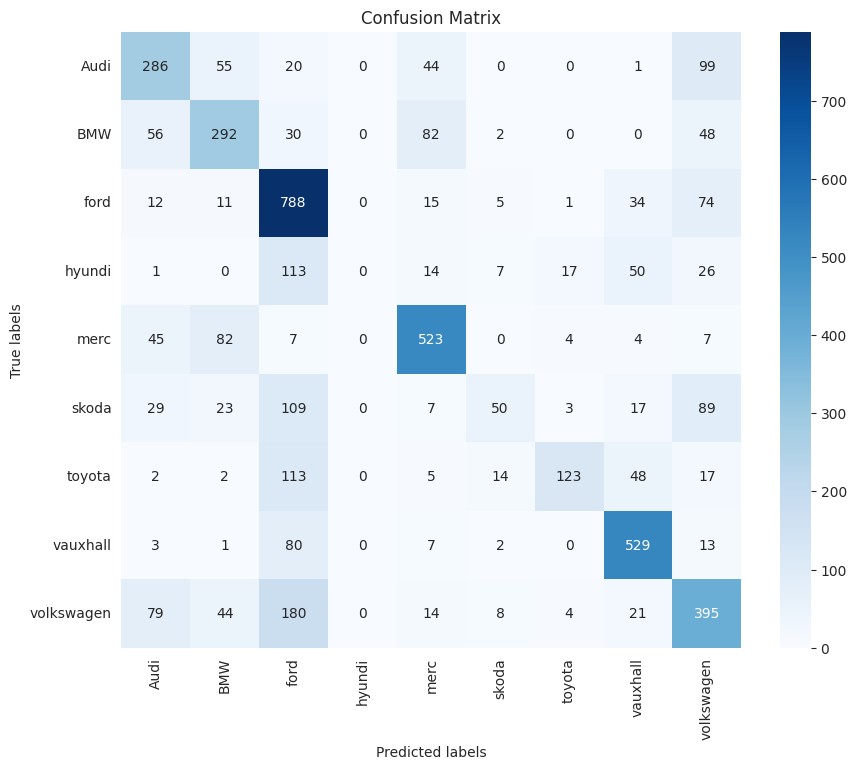


All results:
LR: 0.001, Epochs: 10 => Train Acc: 37.69%, Test Acc: 38.15%
LR: 0.001, Epochs: 20 => Train Acc: 47.28%, Test Acc: 46.89%
LR: 0.001, Epochs: 50 => Train Acc: 53.57%, Test Acc: 53.15%
LR: 0.0001, Epochs: 10 => Train Acc: 61.18%, Test Acc: 59.11%
LR: 0.0001, Epochs: 20 => Train Acc: 62.60%, Test Acc: 59.80%
LR: 0.0001, Epochs: 50 => Train Acc: 64.30%, Test Acc: 61.11%


In [74]:
# Define the grid of hyperparameters
learning_rates2 = [0.001, 0.0001]
num_epochs_list2 = [10, 20, 50]

# Placeholder for the best hyperparameters
best_lr2 = None
best_num_epochs2 = None
best_test_accuracy2 = 0

# Store results for all combinations
results2 = []
# Iterate over all combinations of learning rates and number of epochs
for lr, num_epochs in itertools.product(learning_rates2, num_epochs_list2):
    print(f"Training model with learning rate: {lr} and epochs: {num_epochs}")

    # Reinitialize the model's weights
    initialize_weights(model2)

    # Train the model
    losses = train(model2, train_dataset1A, num_epochs=num_epochs, lr=lr)

    # Evaluate the model on the train dataset
    train_accuracy, _, _ = evaluate(model2, train_dataset1A)

    # Evaluate the model on the test dataset
    test_accuracy, test_all_targets, test_all_predicted = evaluate(model2, test_dataset1A)

    # Save the results
    results2.append((lr, num_epochs, train_accuracy, test_accuracy))

    # Print the accuracies
    print(f'Train accuracy: {train_accuracy * 100:.2f}%')
    print(f'Test accuracy: {test_accuracy * 100:.2f}%')

    # Update the best hyperparameters based on test accuracy
    if test_accuracy > best_test_accuracy2:
        best_test_accuracy2 = test_accuracy
        best_lr2 = lr
        best_num_epochs2 = num_epochs
        best_test_all_targets = test_all_targets
        best_test_all_predicted = test_all_predicted


# Display the best combination
print(f"Best learning rate: {best_lr2}")
print(f"Best number of epochs: {best_num_epochs2}")
print(f"Best test accuracy: {best_test_accuracy2 * 100:.2f}%")

# Plot confusion matrix for the best model
plot_confusion_matrix(best_test_all_targets, best_test_all_predicted, label_encoder1A)

# Optionally, plot or print all results
print("\nAll results:")
for lr, num_epochs, train_acc, test_acc in results2:
    print(f"LR: {lr}, Epochs: {num_epochs} => Train Acc: {train_acc * 100:.2f}%, Test Acc: {test_acc * 100:.2f}%")